In [28]:
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np

In [7]:
import pandas as pd

df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/evaluation.csv')

In [9]:
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

def get_score(sent1, sent2):
    #Compute embedding for both lists
    embedding_1= model.encode(sent1, convert_to_tensor=True)
    embedding_2 = model.encode(sent2, convert_to_tensor=True)

    score = util.pytorch_cos_sim(embedding_1, embedding_2)
    return score

In [33]:
def upsample_data(df_test):
    # separate minority and majority classes
    negative = df_test[df_test.label==0]
    positive = df_test[df_test.label==1]
    # upsample minority
    pos_upsampled = resample(positive,
     replace=True, # sample with replacement
     n_samples=len(negative), # match number in majority class
     random_state=27) # reproducible results
    # combine majority and upsampled minority
    upsampled = pd.concat([negative, pos_upsampled])
    # check new class counts
    print('new distr:', upsampled.label.value_counts())
    
    return upsampled

In [35]:
from sklearn.utils import resample

In [40]:
df_test_ups = upsample_data(df_test).reset_index(drop=True)

new distr: 0    5999
1    5999
Name: label, dtype: int64


In [41]:
score_np = get_score(df_test_ups['text'], df_test_ups['reason'])

In [44]:
y_pred = score_np.diagonal().cpu()
y_true = df_test_ups['label'].to_numpy()

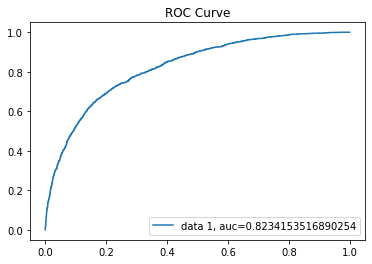

In [45]:
fpr, tpr, _ = metrics.roc_curve(y_true, y_pred)
auc = metrics.roc_auc_score(y_true, y_pred)
plt.plot(fpr, tpr, label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.title('ROC Curve')
plt.show()

In [46]:
thresholds = [0.4, 0.5, 0.6, 0.7, 0.8]

for threshold in thresholds:
        y_pred_thresh = np.where(y_pred>threshold, 1, 0)
        print(f'Classification Report for Threshold {threshold} set:\n', metrics.classification_report(y_true, y_pred_thresh))

Classification Report for Threshold 0.4 set:
               precision    recall  f1-score   support

           0       0.85      0.45      0.59      5999
           1       0.63      0.92      0.75      5999

    accuracy                           0.69     11998
   macro avg       0.74      0.69      0.67     11998
weighted avg       0.74      0.69      0.67     11998

Classification Report for Threshold 0.5 set:
               precision    recall  f1-score   support

           0       0.76      0.69      0.73      5999
           1       0.72      0.78      0.75      5999

    accuracy                           0.74     11998
   macro avg       0.74      0.74      0.74     11998
weighted avg       0.74      0.74      0.74     11998

Classification Report for Threshold 0.6 set:
               precision    recall  f1-score   support

           0       0.67      0.88      0.76      5999
           1       0.82      0.57      0.67      5999

    accuracy                           0.72 

In [ ]:
# we get 74% accuracy with 0.5 as threshold